In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)

import seaborn as sns
sns.set_style('whitegrid')
sns.set_context('paper', font_scale=1.8)

## Load Data

In [2]:
adnimerge_unique = pd.read_csv('data/ADNIMERGE_unique.csv')
print(adnimerge_unique.shape)
adnimerge_unique.head()

(783, 88)


,RID,DX_bl,PTGENDER,PTEDUCAT,PTRACCAT_Asian,PTRACCAT_Black,PTRACCAT_Hawaiian/Other_PI,PTRACCAT_More_than_one,PTRACCAT_Unknown,PTRACCAT_White,PTETHCAT_Not_Hisp/Latino,PTMARRY_Married,PTMARRY_Never_married,PTMARRY_Widowed,APOE4,APOE4_slope,CSF_ABETA,CSF_ABETA_slope,CSF_TAU,CSF_TAU_slope,CSF_PTAU,CSF_PTAU_slope,FDG,FDG_slope,AV45,AV45_slope,CDRSB,CDRSB_slope,ADAS11,ADAS11_slope,ADAS13,ADAS13_slope,MMSE,MMSE_slope,RAVLT_immediate,RAVLT_immediate_slope,RAVLT_learning,RAVLT_learning_slope,RAVLT_forgetting,RAVLT_forgetting_slope,RAVLT_perc_forgetting,RAVLT_perc_forgetting_slope,MOCA,MOCA_slope,EcogPtMem,EcogPtMem_slope,EcogPtLang,EcogPtLang_slope,EcogPtVisspat,EcogPtVisspat_slope,EcogPtPlan,EcogPtPlan_slope,EcogPtOrgan,EcogPtOrgan_slope,EcogPtDivatt,EcogPtDivatt_slope,EcogPtTotal,EcogPtTotal_slope,EcogSPMem,EcogSPMem_slope,EcogSPLang,EcogSPLang_slope,EcogSPVisspat,EcogSPVisspat_slope,EcogSPPlan,EcogSPPlan_slope,EcogSPOrgan,EcogSPOrgan_slope,EcogSPDivatt,EcogSPDivatt_slope,EcogSPTotal,EcogSPTotal_slope,FAQ,FAQ_slope,Ventricles,Ventricles_slope,Hippocampus,Hippocampus_slope,WholeBrain,WholeBrain_slope,Entorhinal,Entorhinal_slope,Fusiform,Fusiform_slope,MidTemp,MidTemp_slope,ICV,ICV_slope
0,4001,2,0,9,0,0,0,0,0,1,1,0,0,1,0.0,0.0,105.7,0.000000e+00,141.6,3.006505e-15,36.2,1.503252e-15,1.11537,0.000033,1.507200,NaN,5.5,0.322375,24.0,0.249574,38.0,0.234855,20.0,-0.186659,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.500,0.053791,1.11111,NaN,1.00000,NaN,1.0,NaN,1.00000,NaN,1.00,NaN,1.14286,NaN,3.875,0.004211,1.00000,0.039147,2.25000,0.043828,3.6,0.013474,3.66667,0.011228,4.00,-0.010675,2.91667,0.018605,22.0,0.147061,33609.0,327.921234,5532.0,-13.555558,864483.0,-1766.049081,2995.0,-64.791139,14530.0,-3.466522,14249.0,-47.827089,1255450.0,-0.543778
1,4004,1,0,14,0,0,0,0,0,1,1,0,0,0,0.0,0.0,208.1,5.096268e-15,83.3,1.274067e-15,33.9,9.555503e-16,1.26220,-0.003933,0.973711,-0.000457,1.5,-0.021869,4.0,0.014977,5.0,0.051461,30.0,0.002234,53.0,-0.036797,5.0,0.033328,9.0,-0.070851,69.2308,-0.499578,27.0,0.047281,1.750,0.006296,1.66667,0.012584,1.85714,2.035398e-02,1.4,0.020378,1.50000,0.007639,2.00,0.009371,1.69231,0.012572,1.625,-0.005569,1.22222,0.000527,1.28571,-0.002936,1.8,-0.013355,1.33333,-0.005150,2.25,-0.016481,1.51282,-0.005680,0.0,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4005,1,1,16,0,0,0,0,0,1,1,1,0,0,1.0,0.0,139.4,0.000000e+00,128.0,0.000000e+00,73.9,9.049212e-16,1.25009,0.000314,1.395770,0.001351,3.5,-0.044936,6.0,0.127031,8.0,0.155971,29.0,0.045185,26.0,0.189440,1.0,-0.024890,6.0,0.011707,100.0000,0.023501,28.0,0.003579,2.125,0.007081,1.00000,0.010400,1.14286,8.180210e-03,1.4,0.004251,1.33333,-0.005677,1.50,0.003515,1.41026,0.005353,3.000,0.013977,2.33333,0.009818,2.57143,0.026097,2.2,0.032259,2.66667,0.018311,2.25,0.023470,2.53846,0.019137,8.0,-0.061578,38294.0,268.520926,7207.0,-3.094318,1181170.0,-945.902809,4405.0,-1.281092,22968.0,-44.868160,22654.0,-40.787854,1768220.0,-346.827114
3,4007,1,1,20,0,0,0,0,0,1,1,1,0,0,1.0,0.0,144.3,4.488822e-15,86.2,-2.244411e-15,40.5,-1.122205e-15,1.33645,0.003553,1.653660,0.002966,0.5,0.031164,9.0,-0.182366,14.0,-0.031164,29.0,0.046588,40.0,-0.174286,7.0,-0.159071,4.0,0.275438,36.3636,2.915744,24.0,-0.054248,1.500,-0.010637,1.00000,0.000000,1.14286,2.273962e-17,1.0,0.000000,1.00000,0.000000,1.00,0.000000,1.12821,-0.002182,2.625,-0.017011,1.55556,-0.026302,1.83333,-0.038269,2.6,-0.071456,1.83333,-0.038823,2.75,-0.036882,2.13158,-0.035686,1.0,-0.003882,36679.0,164.977666,7495.0,-25.103614,1029740.0,-865.813171,3522.0,0.192841,19848.0,-49.114981,19938.0,5.985021,1426170.0,-497.941640
4,4009,2,1,17,0,0,0,0,0,1,0,1,0,0,0.0,0.0,233.9,0.000000e+00,71.4,2.079238e-15,22.1,5.198096e-16,1.17124,-0.001039,0.909650,-0.002026,8.0,0.114822,15.0,0.070772,25.0,0.171000,24.0,0.073440,25.0,-0.222341,1.0,-0.043417,3.0,0.033877,60.0000,1.355067,18.0,-0.013394,2.000,-0.009109,1.33333,-0.009468,2.14286,-3.698373e-02,1.8,-0.017324,2.00000,-0.027624,1.75,-0.018569,1.82051,-0.019639,3.625,0.009662,2.

In [3]:
cols_id = ['RID']
cols_predictand = ['DX_bl']
cols_demographic = [c for c in adnimerge_unique.columns if c.startswith('PT')]
cols_cont_slope = [c for c in adnimerge_unique.columns if c.endswith('slope')]
cols_cont_bl = [c.replace('_slope','') for c in cols_cont_slope]

In [4]:
# Number of patients in each category
num_all = adnimerge_unique.shape[0]
num_CN = np.sum(adnimerge_unique['DX_bl']==0)
num_AD = np.sum(adnimerge_unique['DX_bl']==2)
num_other = num_all - num_CN - num_AD

print('Number of patients in each category after modeling longitudinality:')
print('-------------------------------------------------------------------')
print('total:', num_all)
print('CN    patients:', num_CN)
print('AD    patients:', num_AD)
print('other patients:', num_other)

Number of patients in each category after modeling longitudinality:
-------------------------------------------------------------------
total: 783
CN    patients: 187
AD    patients: 149
other patients: 447


## Histogram

We plotted histograms for each predictor to look at the distribution of each category. To better classify Alzheimer's Disease, we would like to know the relationship of each variable and the diagnosis. In addition, we would like to know how much data is missing in each category of diagnosis and find the best imputing method based on the result.

Here are some noteworthy findings:
- `CDRSB`: All the cognitively normal `CN` patients have a value close to 0. As the value increases, it is more likely that the patient has Alzheimer’s disease. Cognitive impairment and Alzheimer’s Disease `AD` patients can have different values for these two variables. That shows if the value is not 0, then the patient is experiencing some sort of dementia. This could be a very strong predictor. However, `CDRSB` is actively used to deduce DX and will erroneously inflate accuracy. We decided to delete this variable along with its slope.
- `ADAS13`, `CSF_TAU` and `EcogSPMem`: From the plot, it seems that as the value increases, the likelihood of `AD` also increases. It indicates high values are associated with Alzheimer’s Disease. Three categories are well separated.
- `RAVLT_immediate` and `Hippocampus` have negative relationship with Alzheimer’s. As the value of these variables decreases, it is more likely to get AD.
- The missing rate is very low overall. For the predictors that have missing values, the precentage of missing value is similar across each category.

Note: The percentage value in the legend indicates the percentage of data that is not missing in each category

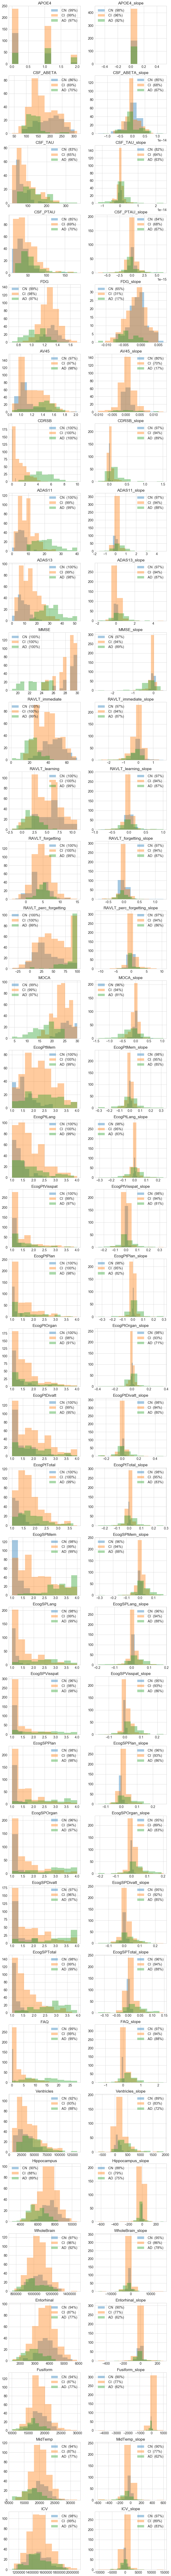

In [5]:
num_cont_bl = len(cols_cont_bl)

adnimerge_unique_CN = adnimerge_unique[adnimerge_unique['DX_bl']==0]
adnimerge_unique_MC = adnimerge_unique[adnimerge_unique['DX_bl']==1]
adnimerge_unique_AD = adnimerge_unique[adnimerge_unique['DX_bl']==2]

fig, ax = plt.subplots(num_cont_bl, 2, figsize=(12,200))

for i,col_name in enumerate(cols_cont_bl):
    mis_rate_CN = np.mean(adnimerge_unique_CN[col_name].isnull())
    mis_rate_MC = np.mean(adnimerge_unique_MC[col_name].isnull())
    mis_rate_AD = np.mean(adnimerge_unique_AD[col_name].isnull())
    adnimerge_unique_CN[col_name].hist(
        ax=ax[i,0], alpha=0.4, 
        label='{:^4} ({:0.0f}%)'.format('CN', 100*(1-mis_rate_CN)))
    adnimerge_unique_MC[col_name].hist(
        ax=ax[i,0], alpha=0.4, 
        label='{:^4} ({:0.0f}%)'.format('CI', 100*(1-mis_rate_MC)))
    adnimerge_unique_AD[col_name].hist(
        ax=ax[i,0], alpha=0.4, 
        label='{:^4} ({:0.0f}%)'.format('AD', 100*(1-mis_rate_AD)))
    ax[i,0].set_title(col_name)
    ax[i,0].legend(loc='best')
    
for i,col_name in enumerate(cols_cont_slope):
    mis_rate_CN = np.mean(adnimerge_unique_CN[col_name].isnull())
    mis_rate_MC = np.mean(adnimerge_unique_MC[col_name].isnull())
    mis_rate_AD = np.mean(adnimerge_unique_AD[col_name].isnull())
    adnimerge_unique_CN[col_name].hist(
        ax=ax[i,1], alpha=0.4, 
        label='{:^4} ({:0.0f}%)'.format('CN', 100*(1-mis_rate_CN)))
    adnimerge_unique_MC[col_name].hist(
        ax=ax[i,1], alpha=0.4, 
        label='{:^4} ({:0.0f}%)'.format('CI', 100*(1-mis_rate_MC)))
    adnimerge_unique_AD[col_name].hist(
        ax=ax[i,1], alpha=0.4, 
        label='{:^4} ({:0.0f}%)'.format('AD', 100*(1-mis_rate_AD)))
    ax[i,1].set_title(col_name)
    ax[i,1].legend(loc='best')

## Correlation Heatmap

To avoid collinearity, we would like to examine the correlation between variables. We used heatmap to do so.

According to the heap map of all selected predictors, there are high correlations between the following
pairs of predictors: `CDRSB` vs `FAQ`, `ADAS11` vs `ADAS13`, `WholeBrain` vs `ICV`, and among all
`EcogXXX` predictors. To deal with these correlations, we deleted `ADAS11`, `EcogPtTotal` and `EcogSPTotal` based on the review of scientific papers that investigate the importance of the factors mentioned above related to the prediction of Alzheimer’s Disease. 

Note: The heatmap is obtained by only considering the value that are not None in both predictors.

In [6]:
def plot_correlation_heatmap(df1, df2, ax):
    df1_copy = df1.copy()
    df2_copy = df2.copy()
    N1 = df1.shape[1]
    N2 = df2.shape[1]
    corr_matrix = np.zeros((N1, N2))
    for i,icol in enumerate(df1.columns):
        for j,jcol in enumerate(df2.columns):
            idx_available = np.where(
                (~df1[icol].isnull()) & (~df2[jcol].isnull()))
            ival = df1[icol].values[idx_available]
            jval = df2[jcol].values[idx_available]
            cov = np.mean(ival*jval) - np.mean(ival)*np.mean(jval)
            corr = cov / np.std(ival) / np.std(jval)
            corr_matrix[i,j] = corr
            
    ax.set_xticks(ticks=range(len(df2.columns)))
    ax.set_yticks(ticks=range(len(df1.columns)))
    ax.set_xticklabels(df2.columns, rotation='vertical')
    ax.set_yticklabels(df1.columns)
    plot = ax.pcolor(np.abs(corr_matrix), vmin=0, vmax=1)
    return plot

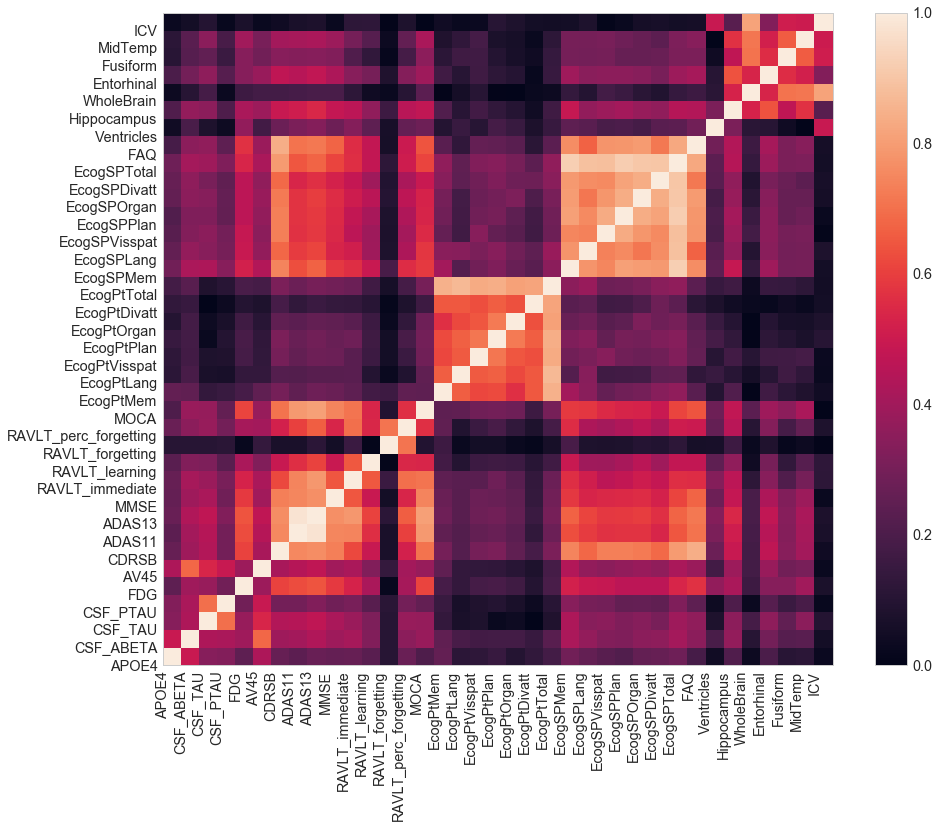

In [7]:
fig, ax = plt.subplots(figsize=(15,12))
plot = plot_correlation_heatmap(
    adnimerge_unique[cols_cont_bl], adnimerge_unique[cols_cont_bl], ax)
fig.colorbar(plot)

We listed the predictors that have a small slope in magnitude related to its value. We deleted these slope variables, `APOE4_slope`, `CSF_ABETA_slope`, `CSF_TAU_slope`, and `CSF_PTAU_slope` as they could not show any trend of the following visits of the patients and were meaningless. We also checked the collinearity of the slopes themselves. We ended up with the same conclusion as above. To deal with these correlations, we deleted `ADAS11_slope`, `EcogPtTotal_slope` and `EcogSPTotal_slope`. Further, we found that the slopes are not collinear with the predictors. 

In [8]:
tol_err = 1e-6
cols_cont_slope_valid = []
for cbl,csl in zip(cols_cont_bl,cols_cont_slope):
    bl = adnimerge_unique[cbl]
    sl = adnimerge_unique[csl]
    if np.std(sl) > tol_err*np.mean(bl):
        cols_cont_slope_valid.append(csl)
cols_cont_slope_invalid = [
    c for c in cols_cont_slope if c not in cols_cont_slope_valid]
print('Predictor slopes that are too small:\n', cols_cont_slope_invalid)

Predictor slopes that are too small:
 ['APOE4_slope', 'CSF_ABETA_slope', 'CSF_TAU_slope', 'CSF_PTAU_slope']


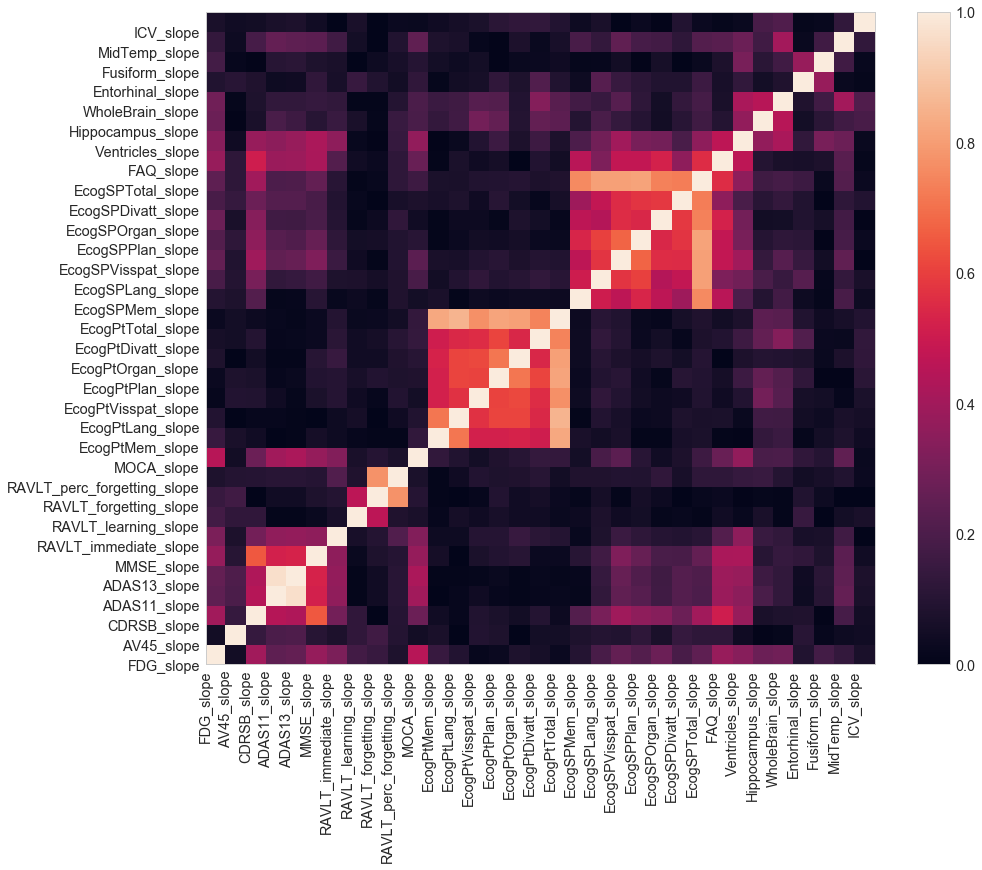

In [9]:
fig, ax = plt.subplots(figsize=(15,12))
plot = plot_correlation_heatmap(
    adnimerge_unique[cols_cont_slope_valid], 
    adnimerge_unique[cols_cont_slope_valid], ax)
fig.colorbar(plot)

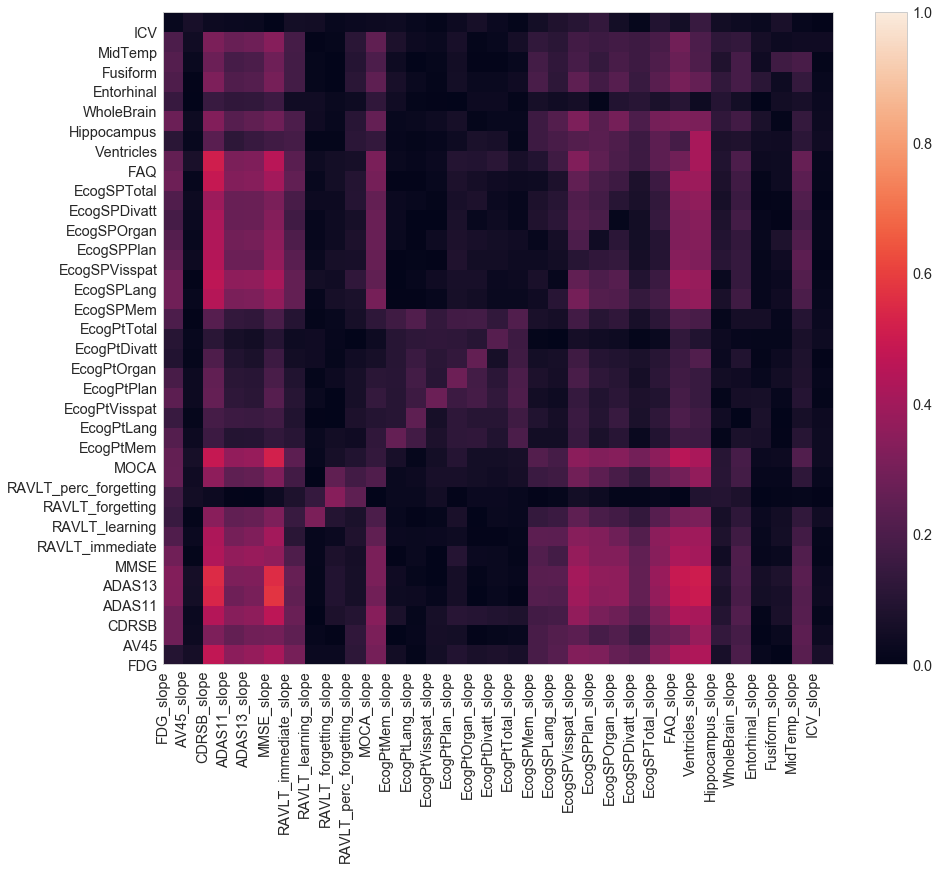

In [10]:
fig, ax = plt.subplots(figsize=(15,12))
plot = plot_correlation_heatmap(
    adnimerge_unique[cols_cont_bl[4:]], 
    adnimerge_unique[cols_cont_slope[4:]], ax)
fig.colorbar(plot)

## Drop Predictors

In [11]:
del adnimerge_unique['CDRSB']
del adnimerge_unique['CDRSB_slope']

del adnimerge_unique['ADAS11']
del adnimerge_unique['EcogPtTotal']
del adnimerge_unique['EcogSPTotal']
del adnimerge_unique['ADAS11_slope']
del adnimerge_unique['EcogPtTotal_slope']
del adnimerge_unique['EcogSPTotal_slope']

del adnimerge_unique['APOE4_slope']
del adnimerge_unique['CSF_ABETA_slope']
del adnimerge_unique['CSF_TAU_slope']
del adnimerge_unique['CSF_PTAU_slope']

In [12]:
print(adnimerge_unique.shape)
adnimerge_unique.head()

(783, 76)


,RID,DX_bl,PTGENDER,PTEDUCAT,PTRACCAT_Asian,PTRACCAT_Black,PTRACCAT_Hawaiian/Other_PI,PTRACCAT_More_than_one,PTRACCAT_Unknown,PTRACCAT_White,PTETHCAT_Not_Hisp/Latino,PTMARRY_Married,PTMARRY_Never_married,PTMARRY_Widowed,APOE4,CSF_ABETA,CSF_TAU,CSF_PTAU,FDG,FDG_slope,AV45,AV45_slope,ADAS13,ADAS13_slope,MMSE,MMSE_slope,RAVLT_immediate,RAVLT_immediate_slope,RAVLT_learning,RAVLT_learning_slope,RAVLT_forgetting,RAVLT_forgetting_slope,RAVLT_perc_forgetting,RAVLT_perc_forgetting_slope,MOCA,MOCA_slope,EcogPtMem,EcogPtMem_slope,EcogPtLang,EcogPtLang_slope,EcogPtVisspat,EcogPtVisspat_slope,EcogPtPlan,EcogPtPlan_slope,EcogPtOrgan,EcogPtOrgan_slope,EcogPtDivatt,EcogPtDivatt_slope,EcogSPMem,EcogSPMem_slope,EcogSPLang,EcogSPLang_slope,EcogSPVisspat,EcogSPVisspat_slope,EcogSPPlan,EcogSPPlan_slope,EcogSPOrgan,EcogSPOrgan_slope,EcogSPDivatt,EcogSPDivatt_slope,FAQ,FAQ_slope,Ventricles,Ventricles_slope,Hippocampus,Hippocampus_slope,WholeBrain,WholeBrain_slope,Entorhinal,Entorhinal_slope,Fusiform,Fusiform_slope,MidTemp,MidTemp_slope,ICV,ICV_slope
0,4001,2,0,9,0,0,0,0,0,1,1,0,0,1,0.0,105.7,141.6,36.2,1.11537,0.000033,1.507200,NaN,38.0,0.234855,20.0,-0.186659,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.500,0.053791,1.11111,NaN,1.00000,NaN,1.0,NaN,1.00000,NaN,1.00,NaN,3.875,0.004211,1.00000,0.039147,2.25000,0.043828,3.6,0.013474,3.66667,0.011228,4.00,-0.010675,22.0,0.147061,33609.0,327.921234,5532.0,-13.555558,864483.0,-1766.049081,2995.0,-64.791139,14530.0,-3.466522,14249.0,-47.827089,1255450.0,-0.543778
1,4004,1,0,14,0,0,0,0,0,1,1,0,0,0,0.0,208.1,83.3,33.9,1.26220,-0.003933,0.973711,-0.000457,5.0,0.051461,30.0,0.002234,53.0,-0.036797,5.0,0.033328,9.0,-0.070851,69.2308,-0.499578,27.0,0.047281,1.750,0.006296,1.66667,0.012584,1.85714,2.035398e-02,1.4,0.020378,1.50000,0.007639,2.00,0.009371,1.625,-0.005569,1.22222,0.000527,1.28571,-0.002936,1.8,-0.013355,1.33333,-0.005150,2.25,-0.016481,0.0,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4005,1,1,16,0,0,0,0,0,1,1,1,0,0,1.0,139.4,128.0,73.9,1.25009,0.000314,1.395770,0.001351,8.0,0.155971,29.0,0.045185,26.0,0.189440,1.0,-0.024890,6.0,0.011707,100.0000,0.023501,28.0,0.003579,2.125,0.007081,1.00000,0.010400,1.14286,8.180210e-03,1.4,0.004251,1.33333,-0.005677,1.50,0.003515,3.000,0.013977,2.33333,0.009818,2.57143,0.026097,2.2,0.032259,2.66667,0.018311,2.25,0.023470,8.0,-0.061578,38294.0,268.520926,7207.0,-3.094318,1181170.0,-945.902809,4405.0,-1.281092,22968.0,-44.868160,22654.0,-40.787854,1768220.0,-346.827114
3,4007,1,1,20,0,0,0,0,0,1,1,1,0,0,1.0,144.3,86.2,40.5,1.33645,0.003553,1.653660,0.002966,14.0,-0.031164,29.0,0.046588,40.0,-0.174286,7.0,-0.159071,4.0,0.275438,36.3636,2.915744,24.0,-0.054248,1.500,-0.010637,1.00000,0.000000,1.14286,2.273962e-17,1.0,0.000000,1.00000,0.000000,1.00,0.000000,2.625,-0.017011,1.55556,-0.026302,1.83333,-0.038269,2.6,-0.071456,1.83333,-0.038823,2.75,-0.036882,1.0,-0.003882,36679.0,164.977666,7495.0,-25.103614,1029740.0,-865.813171,3522.0,0.192841,19848.0,-49.114981,19938.0,5.985021,1426170.0,-497.941640
4,4009,2,1,17,0,0,0,0,0,1,0,1,0,0,0.0,233.9,71.4,22.1,1.17124,-0.001039,0.909650,-0.002026,25.0,0.171000,24.0,0.073440,25.0,-0.222341,1.0,-0.043417,3.0,0.033877,60.0000,1.355067,18.0,-0.013394,2.000,-0.009109,1.33333,-0.009468,2.14286,-3.698373e-02,1.8,-0.017324,2.00000,-0.027624,1.75,-0.018569,3.625,0.009662,2.44444,0.017177,3.71429,0.013120,3.4,0.003900,3.00000,0.032227,2.75,0.043571,26.0,0.235116,29136.0,8.365721,5224.0,-28.069806,910905.0,-3162.821533,NaN,NaN,NaN,NaN,NaN,NaN,1338420.0,-1049.248536


## Imputation

The problem of missing values lies in the continuous variables. We imputed the missing values by mean. We did not impute by regression models because there were very few columns that had no missing data, and we could not build a satisfactory regression model based on that.

In [13]:
def imputation_mean(df, cols):
    df_copy = df.copy()
    for c in cols:
        if c not in df.columns:
            continue
        c_mean = np.mean(df[c])
        df_copy[c] = df[c].map(lambda x:c_mean if np.isnan(x) else x)
    return df_copy

In [14]:
cols_to_impute = cols_cont_bl + cols_cont_slope_valid
adnimerge_unique_imputed = imputation_mean(adnimerge_unique, cols_to_impute)
adnimerge_unique_imputed.head()

,RID,DX_bl,PTGENDER,PTEDUCAT,PTRACCAT_Asian,PTRACCAT_Black,PTRACCAT_Hawaiian/Other_PI,PTRACCAT_More_than_one,PTRACCAT_Unknown,PTRACCAT_White,PTETHCAT_Not_Hisp/Latino,PTMARRY_Married,PTMARRY_Never_married,PTMARRY_Widowed,APOE4,CSF_ABETA,CSF_TAU,CSF_PTAU,FDG,FDG_slope,AV45,AV45_slope,ADAS13,ADAS13_slope,MMSE,MMSE_slope,RAVLT_immediate,RAVLT_immediate_slope,RAVLT_learning,RAVLT_learning_slope,RAVLT_forgetting,RAVLT_forgetting_slope,RAVLT_perc_forgetting,RAVLT_perc_forgetting_slope,MOCA,MOCA_slope,EcogPtMem,EcogPtMem_slope,EcogPtLang,EcogPtLang_slope,EcogPtVisspat,EcogPtVisspat_slope,EcogPtPlan,EcogPtPlan_slope,EcogPtOrgan,EcogPtOrgan_slope,EcogPtDivatt,EcogPtDivatt_slope,EcogSPMem,EcogSPMem_slope,EcogSPLang,EcogSPLang_slope,EcogSPVisspat,EcogSPVisspat_slope,EcogSPPlan,EcogSPPlan_slope,EcogSPOrgan,EcogSPOrgan_slope,EcogSPDivatt,EcogSPDivatt_slope,FAQ,FAQ_slope,Ventricles,Ventricles_slope,Hippocampus,Hippocampus_slope,WholeBrain,WholeBrain_slope,Entorhinal,Entorhinal_slope,Fusiform,Fusiform_slope,MidTemp,MidTemp_slope,ICV,ICV_slope
0,4001,2,0,9,0,0,0,0,0,1,1,0,0,1,0.0,105.7,141.6,36.2,1.11537,0.000033,1.507200,0.000502,38.0,0.234855,20.0,-0.186659,37.18822,-0.103010,4.539052,-0.013343,4.368758,-0.010724,56.16988,0.180313,22.979301,-0.046780,1.500,0.053791,1.11111,-0.000064,1.00000,2.868415e-03,1.0,0.002403,1.00000,0.002204,1.00,0.002802,3.875,0.004211,1.00000,0.039147,2.25000,0.043828,3.6,0.013474,3.66667,0.011228,4.00,-0.010675,22.0,0.147061,33609.000000,327.921234,5532.00000,-13.555558,8.644830e+05,-1766.049081,2995.000000,-64.791139,14530.000000,-3.466522,14249.000000,-47.827089,1.255450e+06,-0.543778
1,4004,1,0,14,0,0,0,0,0,1,1,0,0,0,0.0,208.1,83.3,33.9,1.26220,-0.003933,0.973711,-0.000457,5.0,0.051461,30.0,0.002234,53.00000,-0.036797,5.000000,0.033328,9.000000,-0.070851,69.23080,-0.499578,27.000000,0.047281,1.750,0.006296,1.66667,0.012584,1.85714,2.035398e-02,1.4,0.020378,1.50000,0.007639,2.00,0.009371,1.625,-0.005569,1.22222,0.000527,1.28571,-0.002936,1.8,-0.013355,1.33333,-0.005150,2.25,-0.016481,0.0,0.000000,37648.184722,221.307493,6992.62446,-13.605642,1.043388e+06,-824.231999,3576.089971,-8.352327,18087.830383,-32.266216,19935.085546,-32.674813,1.502300e+06,-124.516227
2,4005,1,1,16,0,0,0,0,0,1,1,1,0,0,1.0,139.4,128.0,73.9,1.25009,0.000314,1.395770,0.001351,8.0,0.155971,29.0,0.045185,26.00000,0.189440,1.000000,-0.024890,6.000000,0.011707,100.00000,0.023501,28.000000,0.003579,2.125,0.007081,1.00000,0.010400,1.14286,8.180210e-03,1.4,0.004251,1.33333,-0.005677,1.50,0.003515,3.000,0.013977,2.33333,0.009818,2.57143,0.026097,2.2,0.032259,2.66667,0.018311,2.25,0.023470,8.0,-0.061578,38294.000000,268.520926,7207.00000,-3.094318,1.181170e+06,-945.902809,4405.000000,-1.281092,22968.000000,-44.868160,22654.000000,-40.787854,1.768220e+06,-346.827114
3,4007,1,1,20,0,0,0,0,0,1,1,1,0,0,1.0,144.3,86.2,40.5,1.33645,0.003553,1.653660,0.002966,14.0,-0.031164,29.0,0.046588,40.00000,-0.174286,7.000000,-0.159071,4.000000,0.275438,36.36360,2.915744,24.000000,-0.054248,1.500,-0.010637,1.00000,0.000000,1.14286,2.273962e-17,1.0,0.000000,1.00000,0.000000,1.00,0.000000,2.625,-0.017011,1.55556,-0.026302,1.83333,-0.038269,2.6,-0.071456,1.83333,-0.038823,2.75,-0.036882,1.0,-0.003882,36679.000000,164.977666,7495.00000,-25.103614,1.029740e+06,-865.813171,3522.000000,0.192841,19848.000000,-49.114981,19938.000000,5.985021,1.426170e+06,-497.941640
4,4009,2,1,17,0,0,0,0,0,1,0,1,0,0,0.0,233.9,71.4,22.1,1.17124,-0.001039,0.909650,-0.002026,25.0,0.171000,24.0,0.073440,25.00000,-0.222341,1.000000,-0.043417,3.000000,0.033877,60.00000,1.355067,18.000000,-0.013394,2.000,-0.009109,1.33333,-0.009468,2.14286,-3.698373e-02,1.8,-0.017324,2.00000,-0.027624,1.75,-0.018569,3.625,0.009662,2.44444,0.017177,3.71429,0.013120,3.4,0.003900,3.00000,0.032227,2.75,0.043571,26.0,0.235116,29136.000000,8.365721,5224.00000,-28.069806,9.109050e+05,-3162.821533,3576.089971,-8.352327,18087.830383,-32.266216,19935.085546,-32.674813,1.338420e+06,-1049.248536


## Train Test Split

We used 80% of the data as training set and the remaining 20% as the test set.

In [15]:
# train test split
np.random.seed(9001)
msk = np.random.rand(adnimerge_unique_imputed.shape[0]) < 0.8
df_train = adnimerge_unique_imputed[msk]
df_test = adnimerge_unique_imputed[~msk]
print(df_train.shape)
print(df_test.shape)

(621, 76)
(162, 76)


In [16]:
# df_train.to_csv('data/ADNIMERGE_train.csv', index=False)
# df_test.to_csv('data/ADNIMERGE_test.csv', index=False)